<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/VGG2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.8MB/s]


Epoch [1/20], Loss: 0.735237
Validation Accuracy: 54.00%
New best model saved with accuracy: 54.00% at /content/drive/My Drive/FYP/VGGModel/Improved_20250209/best_model_vgg_improved_20250209.pth
Epoch [2/20], Loss: 0.392951
Validation Accuracy: 88.00%
New best model saved with accuracy: 88.00% at /content/drive/My Drive/FYP/VGGModel/Improved_20250209/best_model_vgg_improved_20250209.pth
Epoch [3/20], Loss: 0.260934
Validation Accuracy: 97.33%
New best model saved with accuracy: 97.33% at /content/drive/My Drive/FYP/VGGModel/Improved_20250209/best_model_vgg_improved_20250209.pth
Epoch [4/20], Loss: 0.155106
Validation Accuracy: 92.00%
Epoch [5/20], Loss: 0.127444
Validation Accuracy: 92.67%
Epoch [6/20], Loss: 0.109247
Validation Accuracy: 94.67%
Epoch [7/20], Loss: 0.086450
Validation Accuracy: 94.67%
Epoch [8/20], Loss: 0.046765
Validation Accuracy: 98.00%
New best model saved with accuracy: 98.00% at /content/drive/My Drive/FYP/VGGModel/Improved_20250209/best_model_vgg_improved_20250

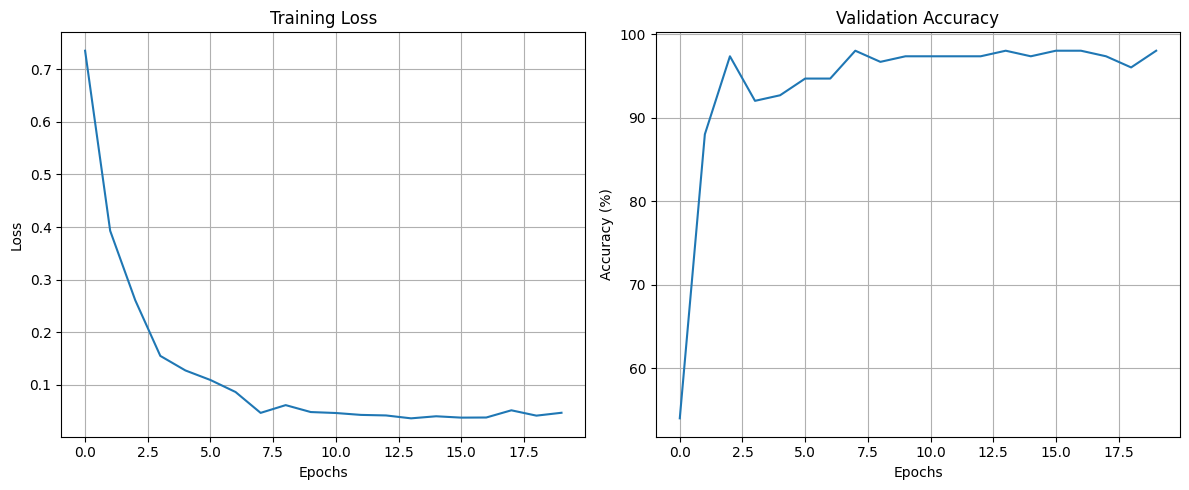

Final model saved at /content/drive/My Drive/FYP/VGGModel/Improved_20250209/final_model_vgg_improved_20250209.pth
Test Loss: 0.163691, Test Accuracy: 89.74%


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/VGGModel/Improved_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQ3/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQ3/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Improved VGG-16 model with fine-tuning and an enhanced classifier
class VGG16Improved(nn.Module):
    def __init__(self, num_classes=2, fine_tune=True):
        super(VGG16Improved, self).__init__()
        from torchvision.models import VGG16_Weights
        self.vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

        # Fine-tune only the later layers: freeze early layers to retain basic feature detectors
        if fine_tune:
            # Example: Freeze the first 10 layers (adjustable based on experimentation)
            for idx, child in enumerate(self.vgg.features.children()):
                if idx < 10:
                    for param in child.parameters():
                        param.requires_grad = False

        # Replace the classifier with a custom architecture
        # This classifier includes Batch Normalization and ReLU activation for improved stability and non-linearity.
        in_features = self.vgg.classifier[0].in_features  # Typically 25088 for VGG-16
        self.vgg.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),           # BatchNorm helps with training stability (&#8203;:contentReference[oaicite:2]{index=2})
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

# Initialize the improved VGG model
model = VGG16Improved().to(device)

# Define loss function and optimizer (only parameters with requires_grad=True are updated)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# Training loop with learning rate scheduler
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.6f}")

        # Validate the model
        val_acc = validate(model, val_loader, criterion)
        val_accuracies.append(val_acc)
        scheduler.step(val_acc)

        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_path = os.path.join(checkpoint_folder, f"best_model_vgg_improved_{date_str}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save the final model
    final_model_path = os.path.join(checkpoint_folder, f"final_model_vgg_improved_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

# Validation loop returning accuracy
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

# Step 1: Train the improved model with learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader, criterion)
